# Problem description

You are to predict whether a company will go bankrupt in the following year, based on financial attributes of the company.

Perhaps you are contemplating lending money to a company, and need to know whether the company
is in near-term danger of not being able to repay.


## Goal

## Learning objectives

- Demonstrate mastery on solving a classification problem and presenting
the entire Recipe for Machine Learning process in a notebook.
- We will make suggestions for ways to approach the problem
    - But there will be little explicit direction for this task.
- It is meant to be analogous to a pre-interview task that a potential employer might assign
to verify your skill

# Import modules

In [1]:
## Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import class_helper

import sklearn
import warnings
warnings.filterwarnings("ignore")

import os
import math

%matplotlib inline


# API for students

In [2]:
## Load the bankruptcy_helper module

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

# Import bankruptcy_helper module
import bankruptcy_helper
%aimport bankruptcy_helper

helper = bankruptcy_helper.Helper()

# Get the data

The first step in our Recipe is Get the Data.

- Each example is a row of data corresponding to a single company
- There are 64 attributes, described in the section below
- The column `Bankrupt` is 1 if the company subsequently went bankrupt; 0 if it did not go bankrupt
- The column `Id` is a Company Identifier

In [3]:
# Data directory
DATA_DIR = "./Data"

if not os.path.isdir(DATA_DIR):
    DATA_DIR = "../resource/asnlib/publicdata/bankruptcy/data"

data_file = "5th_yr.csv"
data = pd.read_csv( os.path.join(DATA_DIR, "train", data_file) )

target_attr = "Bankrupt"

n_samples, n_attrs = data.shape
print("Date shape: ", data.shape)

Date shape:  (4818, 66)


## Have a look at the data

We will not go through all steps in the Recipe, nor in depth.

But here's a peek

In [4]:
data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X57,X58,X59,X60,X61,X62,X63,X64,Bankrupt,Id
0,0.025417,0.41769,0.0568,1.1605,-126.39,0.41355,0.025417,1.2395,1.16500,0.51773,...,0.049094,0.85835,0.12322,5.6167,7.4042,164.310,2.2214,1.334,0,4510
1,-0.023834,0.2101,0.50839,4.2374,22.034,0.058412,-0.027621,3.6579,0.98183,0.76855,...,-0.031011,1.01850,0.069047,5.7996,7.7529,26.446,13.802,6.4782,0,3537
2,0.030515,0.44606,0.19569,1.565,35.766,0.28196,0.039264,0.88456,1.05260,0.39457,...,0.077337,0.95006,0.25266,15.049,2.8179,104.730,3.4852,2.6361,0,3920
3,0.052318,0.056366,0.54562,10.68,438.2,0.13649,0.058164,10.853,1.02790,0.61173,...,0.085524,0.97282,0,6.0157,7.4626,48.756,7.4863,1.0602,0,1806
4,0.000992,0.49712,0.12316,1.3036,-71.398,0,0.001007,1.0116,1.29210,0.50288,...,0.001974,0.99925,0.019736,3.4819,8.582,114.580,3.1854,2.742,0,1529


Pretty *unhelpful* !

What are these mysteriously named features ?

## Description of attributes

This may still be somewhat unhelpful for those of you not used to reading Financial Statements.

But that's partially the point of the exercise
- You can *still* perform Machine Learning *even if* you are not an expert in the problem domain
    - That's what makes this a good interview exercise: you can demonstrate your thought process even if you don't know the exact meaning of the terms
- Of course: becoming an expert in the domain *will improve* your ability to create better models
    - Feature engineering is easier if you understand the features, their inter-relationships, and the relationship to the target

Let's get a feel for the data
- What is the type of each attribute ?


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4818 entries, 0 to 4817
Data columns (total 66 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   X1        4818 non-null   object 
 1   X2        4818 non-null   object 
 2   X3        4818 non-null   object 
 3   X4        4818 non-null   object 
 4   X5        4818 non-null   object 
 5   X6        4818 non-null   object 
 6   X7        4818 non-null   object 
 7   X8        4818 non-null   object 
 8   X9        4818 non-null   float64
 9   X10       4818 non-null   object 
 10  X11       4818 non-null   object 
 11  X12       4818 non-null   object 
 12  X13       4818 non-null   float64
 13  X14       4818 non-null   object 
 14  X15       4818 non-null   object 
 15  X16       4818 non-null   object 
 16  X17       4818 non-null   object 
 17  X18       4818 non-null   object 
 18  X19       4818 non-null   float64
 19  X20       4818 non-null   float64
 20  X21       4818 non-null   obje

You may be puzzled:
- Most attributes are `object` and *not* numeric (`float64`)
- But looking at the data via `data.head()` certainly gives the impression that all attributes are numeric

Welcome to the world of messy data !  The dataset has represented numbers as strings.
- These little unexpected challenges are common in the real-word
- Data is rarely perfect and clean

So you might want to first convert all attributes to numeric

**Hint**
- Look up the Pandas method `to_numeric`
    - We suggest you use the option `errors='coerce'`
    

## convert the non-numerical data back into numerical data  

In [6]:
for col in data.columns[:-2]:
    data[col] = pd.to_numeric(data[col], errors = 'coerce')

Since ID is not a feature, but a company name, so we reset our index into ID 

In [7]:
data.index = data['Id']
del data['Id']

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4818 entries, 4510 to 3294
Data columns (total 65 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   X1        4816 non-null   float64
 1   X2        4816 non-null   float64
 2   X3        4816 non-null   float64
 3   X4        4803 non-null   float64
 4   X5        4808 non-null   float64
 5   X6        4816 non-null   float64
 6   X7        4816 non-null   float64
 7   X8        4804 non-null   float64
 8   X9        4818 non-null   float64
 9   X10       4816 non-null   float64
 10  X11       4816 non-null   float64
 11  X12       4803 non-null   float64
 12  X13       4818 non-null   float64
 13  X14       4816 non-null   float64
 14  X15       4812 non-null   float64
 15  X16       4804 non-null   float64
 16  X17       4804 non-null   float64
 17  X18       4816 non-null   float64
 18  X19       4818 non-null   float64
 19  X20       4818 non-null   float64
 20  X21       4744 non-null   f

## summary of numerical attributes

In [9]:
data.describe()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X56,X57,X58,X59,X60,X61,X62,X63,X64,Bankrupt
count,4816.000000,4816.000000,4816.000000,4803.000000,4.808000e+03,4816.000000,4816.000000,4804.000000,4818.000000,4816.000000,...,4818.000000,4816.000000,4818.000000,4816.000000,4.598000e+03,4806.000000,4818.000000,4803.000000,4735.000000,4818.000000
mean,-0.055232,0.533272,0.188992,4.978602,1.956441e+01,-0.070060,-0.042516,5.739985,1.579277,0.503606,...,0.056109,0.022793,0.959585,0.273025,1.108795e+03,11.021303,177.494445,9.287631,38.557533,0.063927
std,6.707351,1.202909,1.282430,100.273952,2.384491e+04,7.778523,6.707970,109.508001,1.342723,4.044036,...,0.755462,7.249022,0.932427,6.338601,7.106563e+04,43.821146,2279.713700,113.225922,588.711967,0.244648
min,-463.890000,0.000000,-72.067000,0.000000,-1.076400e+06,-463.890000,-463.890000,-3.735100,0.000191,-71.444000,...,-46.788000,-468.670000,-0.085920,-184.980000,-1.244000e+01,-0.092493,0.000000,0.000000,-3.726500,0.000000
25%,0.004047,0.254670,0.044923,1.099200,-4.312000e+01,0.000000,0.005985,0.481588,1.015600,0.318990,...,0.011478,0.015574,0.876940,0.000000,5.298300e+00,4.229925,45.065750,3.074350,2.114850,0.000000
50%,0.046487,0.451495,0.218560,1.642300,3.673450e-01,0.000000,0.056685,1.149000,1.140500,0.522325,...,0.053663,0.108940,0.950825,0.006320,9.038900e+00,6.176800,73.879500,4.928700,4.077200,0.000000
75%,0.116730,0.662178,0.420153,2.929200,4.986775e+01,0.110470,0.136025,2.781300,1.814050,0.721823,...,0.124030,0.240262,0.990358,0.206915,1.720750e+01,9.302800,118.597500,8.067850,9.187600,0.000000
max,2.352300,72.416000,28.336000,6845.800000,1.250100e+06,203.150000,2.352300,6868.500000,37.807000,266.860000,...,1.000000,87.981000,47.788000,308.150000,4.818700e+06,1308.500000,127450.000000,7641.300000,28999.000000,1.000000


plot a histogram for each numerical attribute

By looking at the label, we notice that it is such an inbalanced data!!! It include far more non-bankruptcy company than bankruptcy company

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ffe73642450>]],
      dtype=object)

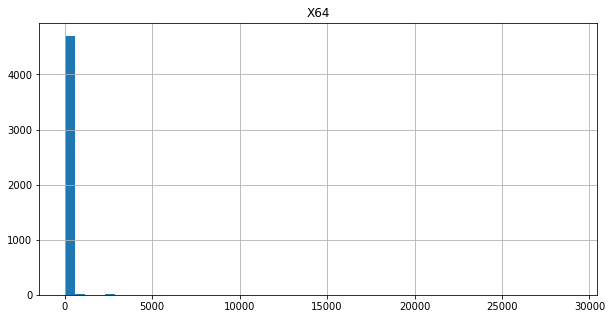

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
data.iloc[:,-2:-1].hist(bins = 50, figsize = (10,5))
plt.show()

By looking at some features, such as X10, it is easier for us to see that the histogram is tail heavy, it will make machine learning algorthms harder to detect the patterns. We will transform these attributes later on to have more bell-shaped distributions. Moreover, these attributes have very different scales, we will also do feature scaling later.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ffe75c49c90>]],
      dtype=object)

(-5, 5)

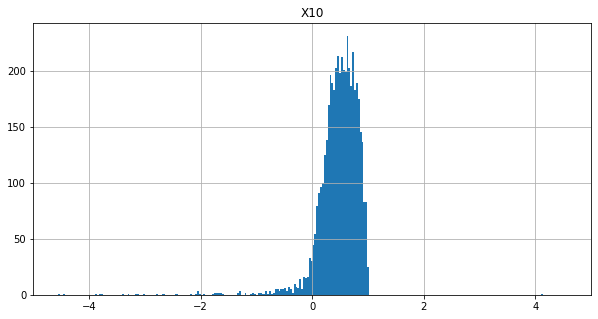

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
data.iloc[:,9:10].hist(bins = 10000, figsize = (10,5))
plt.xlim(-5,5)

plt.show()

In [12]:
data

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X56,X57,X58,X59,X60,X61,X62,X63,X64,Bankrupt
Id,,,,,,,,,,,,,,,,,,,,,
4510,0.025417,0.417690,0.05680,1.16050,-126.3900,0.413550,0.025417,1.23950,1.16500,0.51773,...,0.141650,0.049094,0.85835,0.123220,5.6167,7.4042,164.3100,2.2214,1.3340,0
3537,-0.023834,0.210100,0.50839,4.23740,22.0340,0.058412,-0.027621,3.65790,0.98183,0.76855,...,-0.018502,-0.031011,1.01850,0.069047,5.7996,7.7529,26.4460,13.8020,6.4782,0
3920,0.030515,0.446060,0.19569,1.56500,35.7660,0.281960,0.039264,0.88456,1.05260,0.39457,...,0.049940,0.077337,0.95006,0.252660,15.0490,2.8179,104.7300,3.4852,2.6361,0
1806,0.052318,0.056366,0.54562,10.68000,438.2000,0.136490,0.058164,10.85300,1.02790,0.61173,...,0.027178,0.085524,0.97282,0.000000,6.0157,7.4626,48.7560,7.4863,1.0602,0
1529,0.000992,0.497120,0.12316,1.30360,-71.3980,0.000000,0.001007,1.01160,1.29210,0.50288,...,-0.020100,0.001974,0.99925,0.019736,3.4819,8.5820,114.5800,3.1854,2.7420,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1985,0.211990,0.205850,0.14170,1.79410,72.9810,0.000000,0.265310,3.85790,0.98420,0.79415,...,0.269400,0.266940,0.73275,0.022101,NaN,3.5081,66.1710,5.5160,1.4476,0
3963,0.311900,0.099580,0.57936,10.67900,245.9800,0.000000,0.313170,9.04220,1.05160,0.90042,...,0.285610,0.346400,0.70705,0.044114,14.0180,7.0618,20.7760,17.5680,2.9149,0
4167,-0.029746,0.448980,0.39136,1.93880,7.8073,-0.020006,-0.030561,1.22590,1.00010,0.55040,...,0.000144,-0.054046,0.99986,0.058336,15.5470,8.7022,34.3700,10.6200,23.0860,0


## Create a test set

Split the data
- 90% will be used for training the model
- 10% will be used as validation (out of sample) examples

In [13]:
X = data.iloc[:,:-1]
y = data.iloc[:,-1]
print("Data shape: ", X.shape)
print("Labels shape: ", y.shape)
print("Label values: ", np.unique(y))

Data shape:  (4818, 64)
Labels shape:  (4818,)
Label values:  [0 1]


In [14]:
# Shuffle the data first
X, y = sklearn.utils.shuffle(X, y, random_state=42)

In [15]:
from sklearn.model_selection import train_test_split

X_train = None
X_test = None
y_train = None
y_test = None

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (4336, 64)
X_test shape:  (482, 64)
y_train shape:  (4336,)
y_test shape:  (482,)


In [16]:
data

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X56,X57,X58,X59,X60,X61,X62,X63,X64,Bankrupt
Id,,,,,,,,,,,,,,,,,,,,,
4510,0.025417,0.417690,0.05680,1.16050,-126.3900,0.413550,0.025417,1.23950,1.16500,0.51773,...,0.141650,0.049094,0.85835,0.123220,5.6167,7.4042,164.3100,2.2214,1.3340,0
3537,-0.023834,0.210100,0.50839,4.23740,22.0340,0.058412,-0.027621,3.65790,0.98183,0.76855,...,-0.018502,-0.031011,1.01850,0.069047,5.7996,7.7529,26.4460,13.8020,6.4782,0
3920,0.030515,0.446060,0.19569,1.56500,35.7660,0.281960,0.039264,0.88456,1.05260,0.39457,...,0.049940,0.077337,0.95006,0.252660,15.0490,2.8179,104.7300,3.4852,2.6361,0
1806,0.052318,0.056366,0.54562,10.68000,438.2000,0.136490,0.058164,10.85300,1.02790,0.61173,...,0.027178,0.085524,0.97282,0.000000,6.0157,7.4626,48.7560,7.4863,1.0602,0
1529,0.000992,0.497120,0.12316,1.30360,-71.3980,0.000000,0.001007,1.01160,1.29210,0.50288,...,-0.020100,0.001974,0.99925,0.019736,3.4819,8.5820,114.5800,3.1854,2.7420,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1985,0.211990,0.205850,0.14170,1.79410,72.9810,0.000000,0.265310,3.85790,0.98420,0.79415,...,0.269400,0.266940,0.73275,0.022101,NaN,3.5081,66.1710,5.5160,1.4476,0
3963,0.311900,0.099580,0.57936,10.67900,245.9800,0.000000,0.313170,9.04220,1.05160,0.90042,...,0.285610,0.346400,0.70705,0.044114,14.0180,7.0618,20.7760,17.5680,2.9149,0
4167,-0.029746,0.448980,0.39136,1.93880,7.8073,-0.020006,-0.030561,1.22590,1.00010,0.55040,...,0.000144,-0.054046,0.99986,0.058336,15.5470,8.7022,34.3700,10.6200,23.0860,0


# EDA

## Analyzing Bankcrupt

In [17]:
y_train.describe()

count    4336.000000
mean        0.061808
std         0.240834
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: Bankrupt, dtype: float64

In the following graph, we can see an unbalanced data. Therefore, in the later "preparing the data" section, we will deploy resampling strategy.

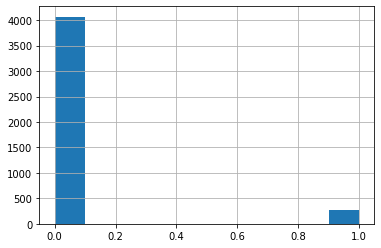

In [18]:
y_train.hist()

## Relationship between bankcrupt and other variables

By looking at relationship between X61(Receivables Turnover) and Bankcrupt, we probably can say that company that has relative low turnover ratio will more likely to go bankcruptcy. That make sense because the lower the turnover of receivables, the longer the time between sale and cash collection, which is bad. 

(-0.5, 1.5, -50, 1373.92962465)

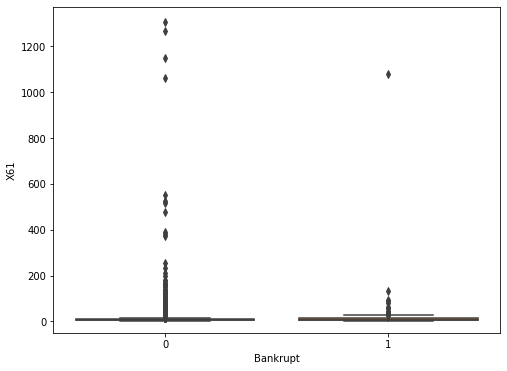

In [19]:
#box plot bankcrupt and X1
import seaborn as sns
var = "X61"
_data = pd.concat([X_train[var], y_train], axis = 1)
f, ax = plt.subplots(figsize = (8, 6))
fig = sns.boxplot(x = "Bankrupt", y = var, data = _data)
fig.axis(ymin = -50, y_max = -5)



## correlation matrix

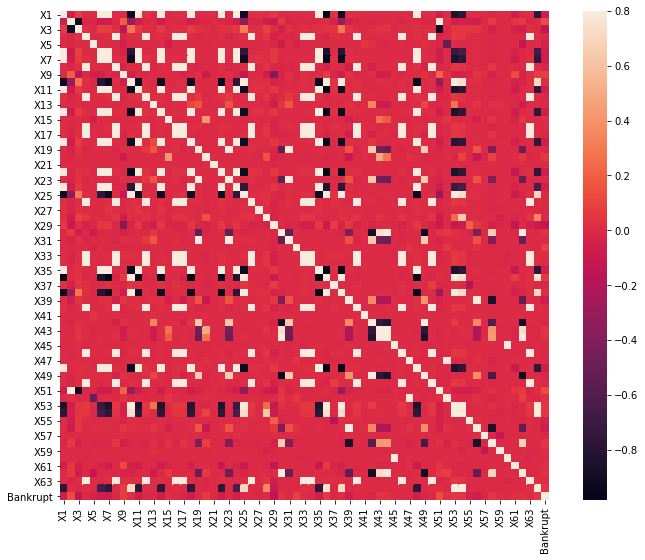

In [20]:
#correlation matrix 
df_train = pd.concat([X_train, y_train], axis = 1)
corrmat = df_train.corr()
f, ax = plt.subplots(figsize = (12, 9))
sns.heatmap(corrmat, vmax = 0.8, square = True)

## zoomed heatmap

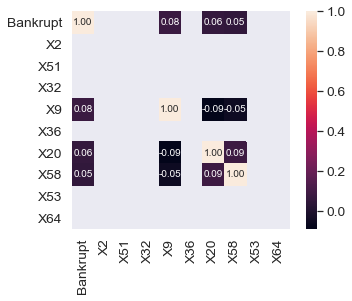

In [21]:
k = 10
cols = corrmat.nlargest(k, 'Bankrupt')['Bankrupt'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale = 1.25)
hm = sns.heatmap(cm, cbar = True, annot = True, square = True, fmt = '.2f'
                , annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

## Scatter plots between correlated variables

In the following graph, you can see some linear relationship between features. Therefore, in the feature engineering section, we need to filtrate some too correlated ones.

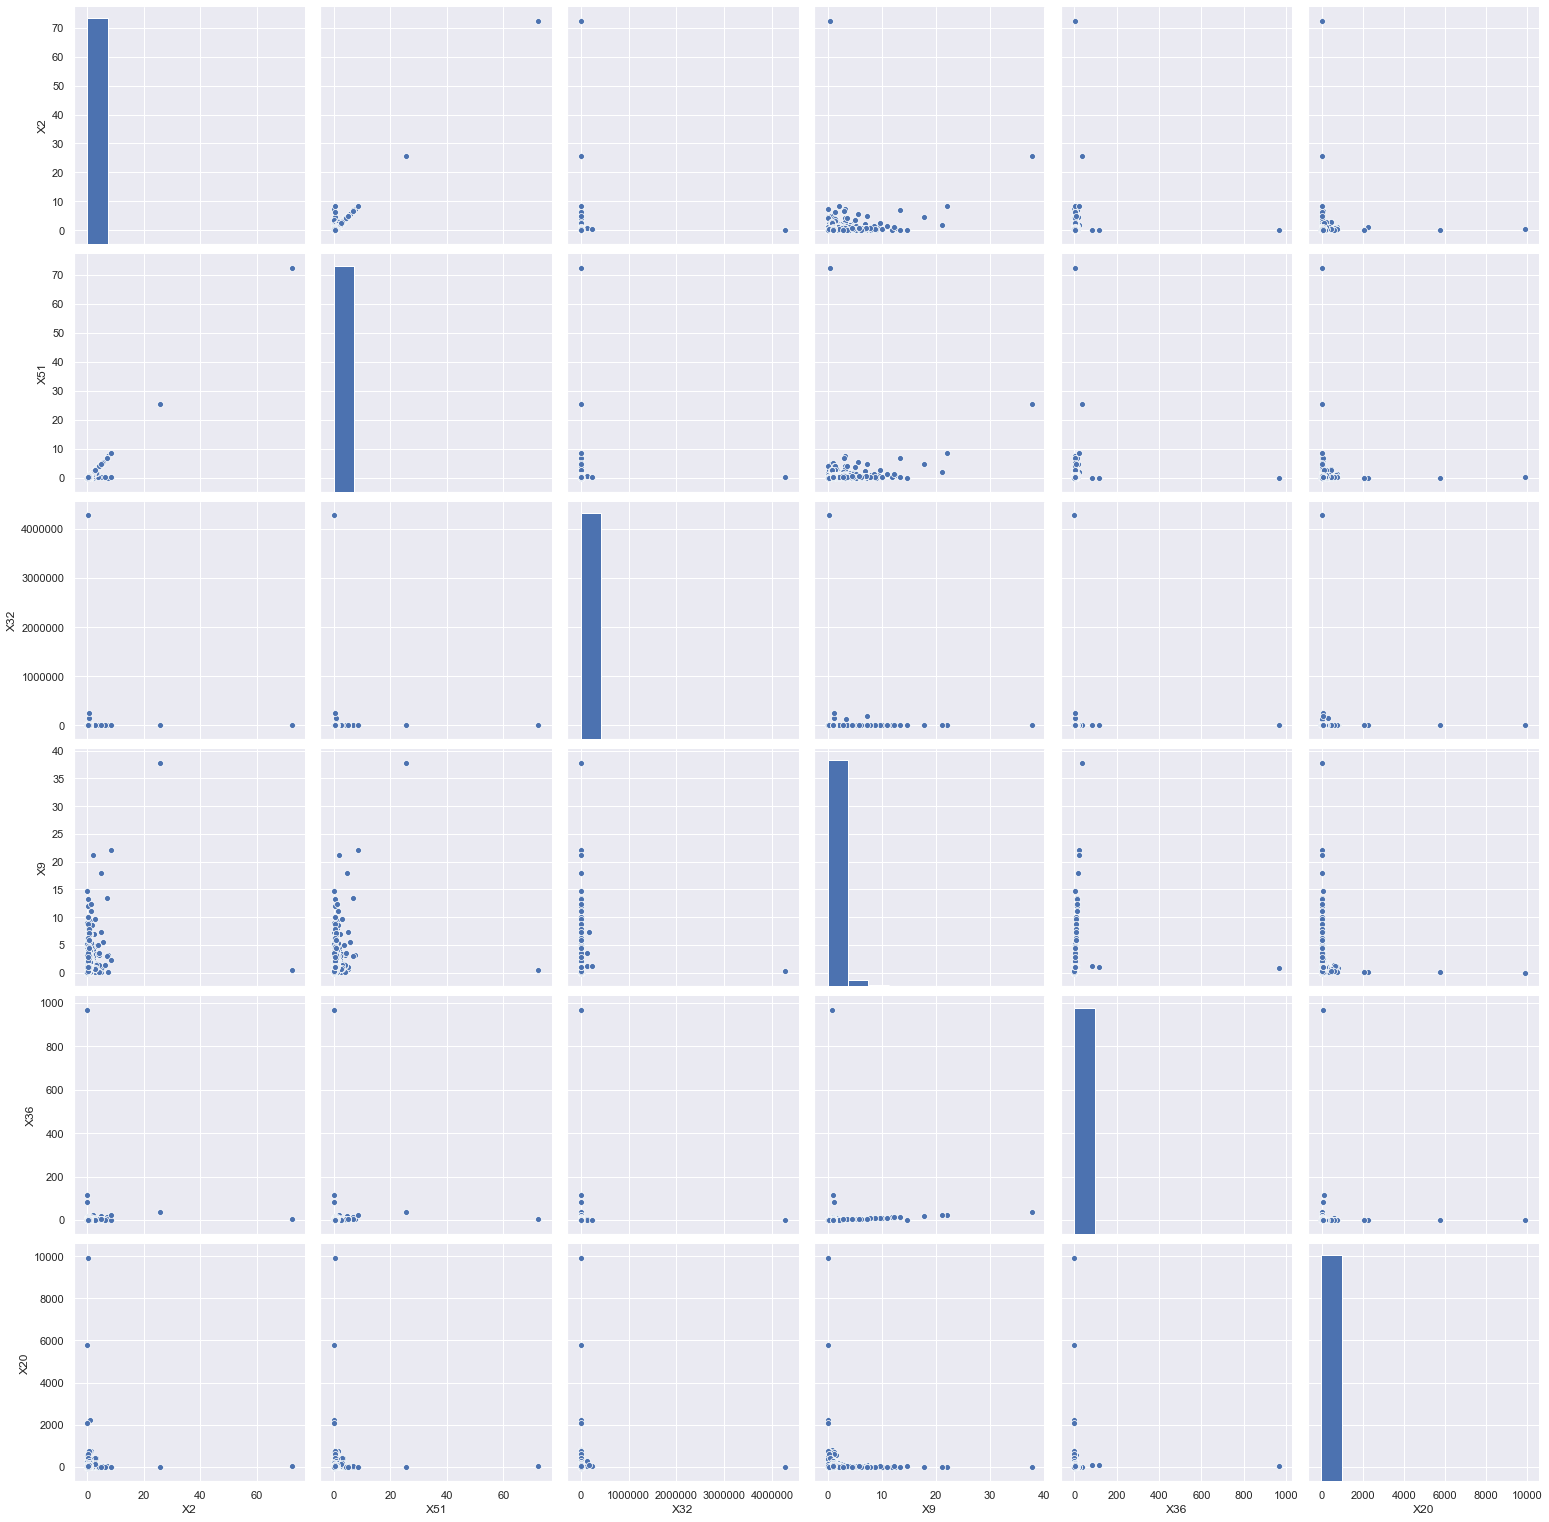

In [22]:
sns.set()
cols = ['X2','X51','X32', 'X9', 'X36', 'X20']
sns.pairplot(df_train[cols], size = 3.5)
plt.show()

## features selection

Since too many features will lead to the overfitting problem, so we will perform features selection by the following step

- train a simple Decision Tree with the whole dataset and get the feature importance for each of the features 
- calculate the correlation among features and drop the high correlated ones

Notice: Since decision tree is not senstitive to imbalanced data and scale. We will perform features selection by decison tree before scaling and dealing with imbalanced dataset

In [23]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = "median")
imputer.fit(X_train)
imputer.statistics_

SimpleImputer(strategy='median')

array([4.66475e-02, 4.50660e-01, 2.19530e-01, 1.64925e+00, 8.06670e-01,
       0.00000e+00, 5.70095e-02, 1.15240e+00, 1.14395e+00, 5.23170e-01,
       7.19780e-02, 1.67810e-01, 6.78220e-02, 5.70650e-02, 9.10920e+02,
       2.36020e-01, 2.21280e+00, 5.70650e-02, 3.56115e-02, 3.87215e+01,
       1.11950e+00, 6.21115e-02, 3.03905e-02, 1.63495e-01, 4.25220e-01,
       2.10130e-01, 9.96020e-01, 5.28190e-01, 4.17500e+00, 2.24430e-01,
       4.30710e-02, 8.07190e+01, 4.49030e+00, 1.71820e+00, 6.18520e-02,
       1.55210e+00, 3.69010e+00, 6.19690e-01, 4.02275e-02, 1.83650e-01,
       9.33645e-02, 4.04620e-02, 1.06490e+02, 5.89500e+01, 2.64005e-01,
       1.06955e+00, 4.21960e+01, 2.00035e-02, 1.23795e-02, 1.29100e+00,
       3.28550e-01, 2.20785e-01, 1.27730e+00, 1.42260e+00, 1.87795e+03,
       5.34895e-02, 1.09020e-01, 9.50980e-01, 6.32050e-03, 8.99855e+00,
       6.18130e+00, 7.37785e+01, 4.93150e+00, 4.07720e+00])

In [24]:
X_train_ = imputer.transform(X_train)
X_train_ = pd.DataFrame(X_train_, columns = X_train.columns)

In [25]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier().fit(X_train_, y_train)
tree.feature_importances_
df_feature_importance = pd.DataFrame(tree.feature_importances_, index=X_train_.columns, columns=['feature importance']).sort_values('feature importance', ascending=False)
df_feature_importance

array([0.00198858, 0.00684167, 0.01020863, 0.02133288, 0.01177518,
       0.00745718, 0.        , 0.00198858, 0.01978691, 0.        ,
       0.        , 0.01025225, 0.01784941, 0.01952923, 0.01952898,
       0.00596575, 0.00530289, 0.        , 0.        , 0.0101323 ,
       0.0174471 , 0.0092529 , 0.        , 0.03860904, 0.00583022,
       0.00422149, 0.03692055, 0.00377943, 0.02497781, 0.00677057,
       0.        , 0.003409  , 0.00382415, 0.10286381, 0.13412278,
       0.03773175, 0.00776409, 0.01486337, 0.00318173, 0.01996093,
       0.00864129, 0.02100822, 0.00975257, 0.01583188, 0.02192778,
       0.08444354, 0.00192117, 0.00298287, 0.02389774, 0.00265144,
       0.        , 0.        , 0.00777996, 0.02249311, 0.01170952,
       0.03829012, 0.00812076, 0.0151511 , 0.00265144, 0.01781161,
       0.0064832 , 0.        , 0.01179892, 0.0191806 ])

,feature importance
X35,0.134123
X34,0.102864
X46,0.084444
X24,0.038609
X56,0.038290
...,...
X10,0.000000
X51,0.000000
X62,0.000000
X7,0.000000


Here we can visulaize our feature importance score

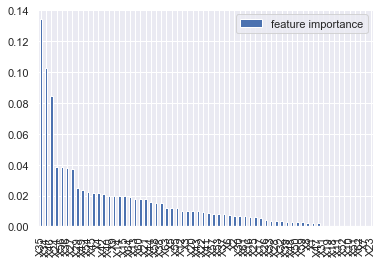

In [26]:
df_feature_importance.plot(kind = 'bar')

Based on our intial selection, we only choose feature which feature importance score is greater than 0.02

In [27]:
df_feature_importance[df_feature_importance.values > 0.02].index
cols = df_feature_importance[df_feature_importance.values > 0.02].index

Index(['X35', 'X34', 'X46', 'X24', 'X56', 'X36', 'X27', 'X29', 'X49', 'X54',
       'X45', 'X4', 'X42'],
      dtype='object')

Our next step is to filtrate some variables that have have correlation to avoid multicollinearity

- Based on the following heatmap, we still can see lots of high correlated pairs

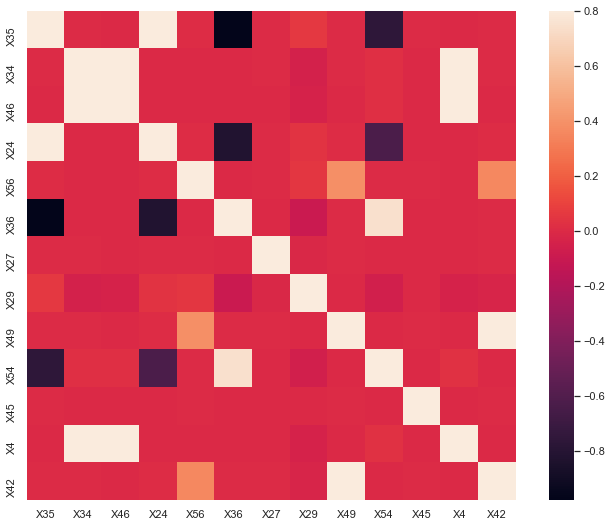

In [28]:
corrmat = X_train_[cols].corr()
f, ax = plt.subplots(figsize = (12, 9))
sns.heatmap(corrmat, vmax = 0.8, square = True)

After we initiallly selected some features based on importance score, we will filtrate the high correlated pairs which correlation are higher than 0.3.

Rank the correlation and find the too correlated pairs

In [29]:
corr_ = X_train_[cols].corr().abs()
# s = corr_.unstack()
# s_ = s.sort_values(kind = 'quicksort', ascending = False)
# s_ = (s_[(s_.values <  1)])

s_ = corr_.mask(np.tril(np.ones(corr_.shape)).astype(np.bool))
s_ = s_[abs(s_) < 1].stack().reset_index()
s_ = s_.sort_values(by = 0, kind = 'quicksort', ascending = False)

In [30]:
s_[s_[0] > 0.3]

,level_0,level_1,0
31,X46,X4,0.999799
12,X34,X46,0.989245
21,X34,X4,0.988395
4,X35,X36,0.979910
71,X49,X42,0.964864
2,X35,X24,0.833288
34,X24,X36,0.821409
8,X35,X54,0.762070
53,X36,X54,0.749425
38,X24,X54,0.631765


In [31]:
df_feature_importance.T[cols]

,X35,X34,X46,X24,X56,X36,X27,X29,X49,X54,X45,X4,X42
feature importance,0.134123,0.102864,0.084444,0.038609,0.03829,0.037732,0.036921,0.024978,0.023898,0.022493,0.021928,0.021333,0.021008


Based on our selection process, we selected features that have high feature importance score. Moreover, corrleation among selected features are very low.

As you can see the follwing graph, the correlation bewteen selected features are pretty low! We achieve our goal!

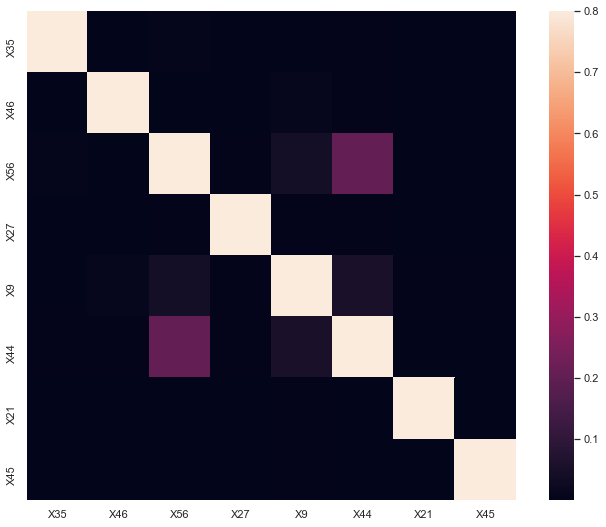

In [32]:
corrmat = X_train_[['X35', 'X46', 'X56', 'X27', 'X9', 'X44', 'X21', 'X45']].corr().abs()
f, ax = plt.subplots(figsize = (12, 9))
sns.heatmap(corrmat, vmax = 0.8, square = True)

# Prepare the data and classfier, deal with imbalanced dataset and train the model

Before we train the model, we will perform data transformation.

- scaler
- filling missing value by median 
- use SMOTETomek to deal with imbalanced data

In [33]:
X_train = X_train[['X35', 'X46', 'X56', 'X27', 'X9', 'X44', 'X21', 'X45']]
X_test = X_test[['X35', 'X46', 'X56', 'X27', 'X9', 'X44', 'X21', 'X45']]

Since our dataset is high inbanlanced, so we will use the following technique to deal with inbanalnced data.
We will do a combination of over-sampling and under-sampling, using the SMOTE and Tomek links techniques

In [34]:
import time
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import accuracy_score
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer

scaler = None
scaler = StandardScaler()
## Classification Model
#  Create a classifier
#    clf: sklearn classifier
#    name: string, name of your classifier
#    model_pipeline: sklearn Pipeline, if you use pipeline, please use this variable

clf = None
name = None 
clf = LogisticRegression(solver = 'liblinear')
smt = SMOTETomek(random_state = 42)
# smt = SMOTE(random_state = 42)
name = "LogisticRegression"

model_pipeline = Pipeline(steps = [('imputer', SimpleImputer(strategy = 'median')), ('scale', scaler), ('sampling', smt), ('clf', clf)])


## train the model and calculate in-sample accuracy

The in sample accuracy is 0.81,so we don't have overfitting problem. However,we are a little underfit. 

In [35]:
from sklearn.metrics import accuracy_score
from imblearn.combine import SMOTETomek
# Set variable
# score_in_sample: a scalar number, score for your in-sample examples
score_in_sample = None


model_pipeline.fit(X_train, y_train)
score_in_sample = accuracy_score(y_train, model_pipeline.predict(X_train))

print("Model: {m:s} in sample score={s:3.2f}\n".format(m=name, s=score_in_sample))

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scale', StandardScaler()),
                ('sampling', SMOTETomek(random_state=42)),
                ('clf', LogisticRegression(solver='liblinear'))])

Model: LogisticRegression in sample score=0.81



## Train the model using Cross Validation


- Use 5-fold Cross Validation
    - Set cross_val_scores
    - Set k as the number of folds
    - Report the average score



In [36]:
cross_val_scores = None
k = 5
t0 = time.time()

# YOUR CODE HERE

cross_val_scores = cross_val_score(model_pipeline, X_train, y_train, cv= k)

print("Model: {m:s} avg cross validation score={s:3.2f}\n".format(m=name, s=cross_val_scores.mean()) )

Model: LogisticRegression avg cross validation score=0.81



## compare the model (no feature engineering) and model (with features selection)

As you can see, the cross validation score do improve when we perform feature selection!

In [37]:
cross_val_scores_ = cross_val_score(model_pipeline, df_train.iloc[:,:-1], y_train, cv= k)

print("Model: {m:s} avg cross validation score <no feature engineering> ={s:3.2f}\n".format(m=name, s=cross_val_scores_.mean()) )

Model: LogisticRegression avg cross validation score <no feature engineering> =0.80



In [38]:
print("Model: {m:s} avg cross validation score <with feature engineering >={s:3.2f}\n".format(m=name, s=cross_val_scores.mean()) )

Model: LogisticRegression avg cross validation score <with feature engineering >=0.81



## Performance measure: logistic regression

confusion matrix

In [39]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(model_pipeline, X_train, y_train, cv = k)

In [40]:
from sklearn.metrics import confusion_matrix
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[3353,  715],
       [ 107,  161]])

Precision and recall

As you can see, based on the precision and call score, when it claims that the company will go bankrupt, it is correct only 18.37% of the time. Moreover, it only detects 60% bankrupt company.


In [41]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train, y_train_pred)
recall_score(y_train, y_train_pred)

0.18378995433789955

0.6007462686567164

Calculate F1 score

- F1 score is the harmonic mean of precision and recall. And gives more weight to low values.
- F1 score favors classifiers that have similar precision and recall

As we can see the harmonic value is also bad becasuse our recall and precesion score are low and not similar.

In [42]:
from sklearn.metrics import f1_score
f1_score(y_train, y_train_pred)

0.28146853146853146

In [43]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train, model_pipeline.predict(X_train))

# Convert thresholds (log odds) to probability
probs = np.exp(thresholds)/(1+np.exp(thresholds))

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds, probs=None):
    fig, ax = plt.subplots(1,1, figsize=(12,4))
    
    if probs is None:
        horiz = thresholds
        label = "Threshold"
    else:
        horiz = probs
        label = "Probability threshold"
    _ = ax.plot(horiz, precisions[:-1], "b--", label="Precision", linewidth=2)
    _ = ax.plot(horiz, recalls[:-1], "g-", label="Recall", linewidth=2)
    _ = ax.set_xlabel(label, fontsize=16)
    _ = ax.legend(loc="upper left", fontsize=16)
    _ = ax.set_ylim([0, 1])
    
    _ = ax.set_xlim([ horiz.min(), horiz.max()])
    
    return fig, ax

fig, ax = plot_precision_recall_vs_threshold(precisions, recalls, thresholds, probs=probs)
plt.close(fig)

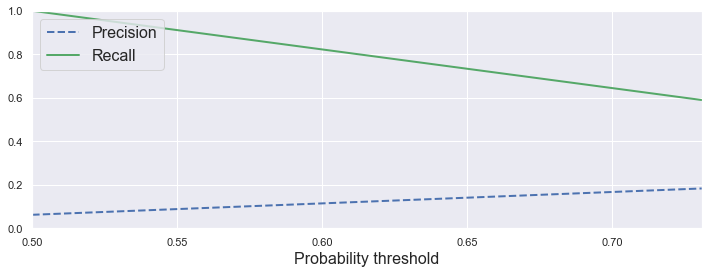

In [44]:
fig

In [45]:
imputer = SimpleImputer(strategy = "median")
imputer.fit(X_train)
X_train_ = imputer.transform(X_train)
X_test_ = imputer.transform(X_test)

SimpleImputer(strategy='median')

A perfect classifier will have a ROC AUC eual to 1, as we can see random forest AUC score is highest 

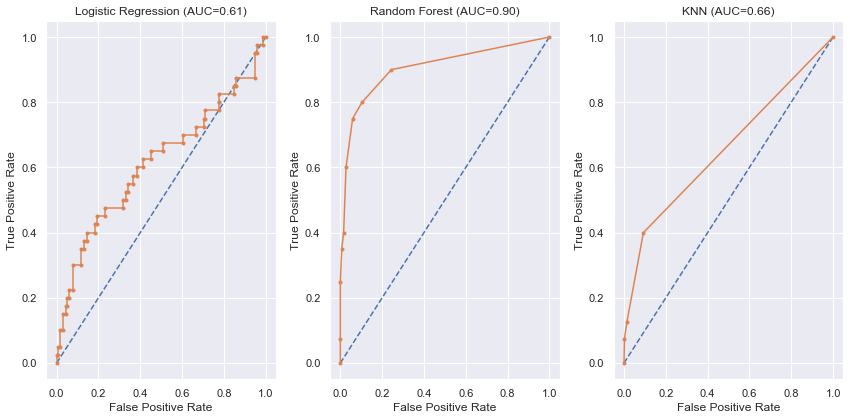

In [46]:
import class_helper

clh= class_helper.Classification_Helper(random_seed=42)
clh.AUC_plot(X_train=X_train_, y_train=y_train, X_test=X_test_, y_test= y_test)

## error analysis

By looking at the follwing graph, we can see that prediction is pretty bad when the true label is positive.

array([[3353,  715],
       [ 107,  161]])

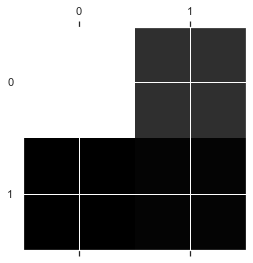

In [47]:
conf_mx
plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()

Lets focus on plot on errors. Now, it become more clear. Rows represent actual classes. When the square is bright, it tells you that many images are misclassified. The model misclssfied many bankrupt (label 1) as label 0.

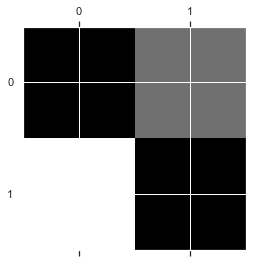

In [48]:
row_sums = conf_mx.sum(axis = 1, keepdims = True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()

## Trade off between precision and recall

-  The higher the recall, the more false positives the classifier produces. In our case, we prefer high recall because failing to identify the firm that will go bankcrupt will be much worse. 

In order to get the appropriate threhold, we will get the scores of all instances in the training set using cross_val_predict() and return will be decision scores instead of predictions

In [49]:
y_scores = cross_val_predict(clf, X_train_, y_train, cv = 5, method = "decision_function")

In [50]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

In [51]:
def plot_precision_recall_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label = "Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label = "Recall")

As you can see, logistic regression perform pretty bad because there is a big amount of time the recall score is 1. It means that the model just consistenly label all the company as bankcrupt. And then, there is a big drop.

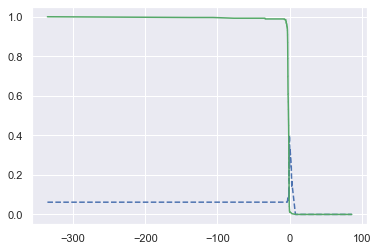

In [52]:
plot_precision_recall_threshold(precisions, recalls, thresholds)
plt.show()

Becase we prefer high recall score, so we will adjust the threhold here.

As you can see, when we adjust the threholds to make sure that the recall score will be larger than 0.8, precision score and accuracy score will be prettry low. It suggests that logistic regression may not be a good model.

In [53]:
threshold_80_recall = thresholds[np.argmax(recalls >= 0.8)]
y_train_pred_80 = (y_scores >= threshold_80_recall)
print("precision score: ", precision_score(y_train,y_train_pred_80))
print("recall score: ", recall_score(y_train,y_train_pred_80))
print("accuracy score", accuracy_score(y_train, y_train_pred_80))

precision score:  0.06183664051684356
recall score:  1.0
accuracy score 0.06226937269372694


## feature engineering: Add more sythetic features and normalization

It is time to perform feature engineering!
- add polynomial features

In [54]:
from sklearn.preprocessing import PolynomialFeatures
feature_map_poly2 = PolynomialFeatures(2)

model_pipeline_new = Pipeline(steps = [('imputer', SimpleImputer(strategy = 'median')), ("feature map", feature_map_poly2),
                                       ('scale', scaler), ('sampling', smt), ('clf', clf)])



As you can see even though the cross validation score decrease from 0.81 to 0.77, the recall score do improve from 0.60 to 0.63 !

In [55]:
cross_val_scores = cross_val_score(model_pipeline_new, X_train, y_train, cv= k)

print("Model: {m:s} avg cross validation score={s:3.2f}\n".format(m=name, s=cross_val_scores.mean()) )

Model: LogisticRegression avg cross validation score=0.77



In [56]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(model_pipeline_new, X_train, y_train, cv = k)
from sklearn.metrics import confusion_matrix
conf_mx = confusion_matrix(y_train, y_train_pred)
precision_score(y_train, y_train_pred)
recall_score(y_train, y_train_pred)

0.16052880075542966

0.6343283582089553

## Add a regularization penalty 

Actually the default regularization term is I2, so here we will try 2 cases. First, change the regularization term to l1 and evaluate the result. Second,  improve regularization strength parameter C and evaluate the result.

- change L2 to L1

In [57]:
clf = LogisticRegression(solver = "liblinear", penalty = "l1")
model_pipeline_new = Pipeline(steps = [('imputer', SimpleImputer(strategy = 'median')), ("feature map", feature_map_poly2),
                                       ('scale', scaler), ('sampling', smt), ('clf', clf)])

cross_val_scores = cross_val_score(model_pipeline_new, X_train, y_train, cv= k)

print("Model: {m:s} avg cross validation score={s:3.2f}\n".format(m=name, s=cross_val_scores.mean()) )

Model: LogisticRegression avg cross validation score=0.77



As you can see, when we change the regularization term to L1, both the recall score and precision score improve. And recall score has been improved from 0.63 to 0.67!

In [58]:
y_train_pred = cross_val_predict(model_pipeline_new, X_train, y_train, cv = k)
conf_mx = confusion_matrix(y_train, y_train_pred)
precision_score(y_train, y_train_pred)
recall_score(y_train, y_train_pred)

0.16791044776119404

0.6716417910447762

- Improve regularization strength parameter C

As you can see, when we improve the strength parameter C, the recall score decrease.

In [59]:
clf = LogisticRegression(solver = "liblinear", C = 0.5)
model_pipeline_new = Pipeline(steps = [('imputer', SimpleImputer(strategy = 'median')), ("feature map", feature_map_poly2),
                                       ('scale', scaler), ('sampling', smt), ('clf', clf)])

cross_val_scores = cross_val_score(model_pipeline_new, X_train, y_train, cv= k)

print("Model: {m:s} avg cross validation score={s:3.2f}\n".format(m=name, s=cross_val_scores.mean()) )

Model: LogisticRegression avg cross validation score=0.77



In [60]:
y_train_pred = cross_val_predict(model_pipeline_new, X_train, y_train, cv = k)
conf_mx = confusion_matrix(y_train, y_train_pred)
precision_score(y_train, y_train_pred)
recall_score(y_train, y_train_pred)

0.1568627450980392

0.6268656716417911

## evaluate another model: random forest

Based on the following graph, it is eaiser to see that random forest has a highest AUC score. Therefore, we will use random forest as our next model

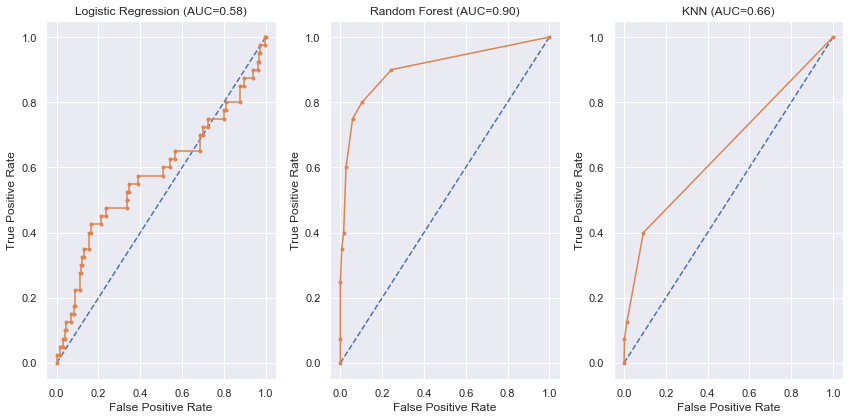

In [61]:
import class_helper

clh= class_helper.Classification_Helper(random_seed=42)
clh.AUC_plot(X_train=X_train_, y_train=y_train, X_test=X_test_, y_test= y_test)

As we can see, the avg corss validation increase a lot, but recall score decrease. That's not what we want. We prefer high recall in this case because we want to identify the company that will go bankcrupt.

In [62]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state = 0)

model_pipeline_new = Pipeline(steps = [('imputer', SimpleImputer(strategy = 'median')), ("feature map", feature_map_poly2),
                                       ('scale', scaler), ('sampling', smt), ('clf', clf)])

cross_val_scores = cross_val_score(model_pipeline_new, X_train, y_train, cv= k)

print("Model: {m:s} avg cross validation score={s:3.2f}\n".format(m= "random forest", s=cross_val_scores.mean()) )


Model: random forest avg cross validation score=0.93



In [63]:
y_train_pred = cross_val_predict(model_pipeline_new, X_train, y_train, cv = k)
conf_mx = confusion_matrix(y_train, y_train_pred)
precision_score(y_train, y_train_pred)
recall_score(y_train, y_train_pred)

0.4378698224852071

0.5522388059701493

In [64]:
f1_score(y_train, y_train_pred)

0.4884488448844885

## more feature engineering

Here when can see when we remove polynomial features in this case, andom forest avg cross validation score doesn't change, but recall improve to 0.61.

In [65]:
model_pipeline_new = Pipeline(steps = [('imputer', SimpleImputer(strategy = 'median')),
                                       ('scale', scaler), ('sampling', smt), ('clf', clf)])

cross_val_scores = cross_val_score(model_pipeline_new, X_train, y_train, cv= k)

print("Model: {m:s} avg cross validation score={s:3.2f}\n".format(m= "random forest", s=cross_val_scores.mean()) )
y_train_pred = cross_val_predict(model_pipeline_new, X_train, y_train, cv = k)
conf_mx = confusion_matrix(y_train, y_train_pred)
print("precision:", precision_score(y_train, y_train_pred))
print("recall:", recall_score(y_train, y_train_pred))

Model: random forest avg cross validation score=0.92

precision: 0.39518072289156625
recall: 0.6119402985074627


## evaluate another model: decision tree

Since decision tree is not sensitive to the imbalaned data and scaler, we will evaluate the decision tree in our case

At first, we will test the model with scaler and sampling to see the result. 
As you can see the model still not perform very well and have a low recall score

In [66]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)
model_pipeline_new = Pipeline(steps = [('imputer', SimpleImputer(strategy = 'median')),
                                       ('scale', scaler), ('sampling', smt), ('clf', clf)])

cross_val_scores = cross_val_score(model_pipeline_new, X_train, y_train, cv= k)

print("Model: {m:s} avg cross validation score={s:3.2f}\n".format(m= "decision tree", s=cross_val_scores.mean()) )


Model: decision tree avg cross validation score=0.87



In [67]:
y_train_pred = cross_val_predict(model_pipeline_new, X_train, y_train, cv = k)
conf_mx = confusion_matrix(y_train, y_train_pred)
print("precision:", precision_score(y_train, y_train_pred))
print("recall:", recall_score(y_train, y_train_pred))

precision: 0.25396825396825395
recall: 0.5373134328358209


Since decision tree is not sensitive to the imbalaned data and scaler, we will reomve sampling technique and scaler in our case to see the result

As you can see, even though the accuracy of decision improve in this case, the recall decrease a lot. It is still a undesirable result.

In [68]:
clf = DecisionTreeClassifier(random_state=0)
model_pipeline_new = Pipeline(steps = [('imputer', SimpleImputer(strategy = 'median')), ('clf', clf)])

cross_val_scores = cross_val_score(model_pipeline_new, X_train, y_train, cv= k)

print("Model: {m:s} avg cross validation score={s:3.2f}\n".format(m= "decision tree", s=cross_val_scores.mean()) )


Model: decision tree avg cross validation score=0.92



In [69]:
y_train_pred = cross_val_predict(model_pipeline_new, X_train, y_train, cv = k)
conf_mx = confusion_matrix(y_train, y_train_pred)
print("precision:", precision_score(y_train, y_train_pred))
print("recall:", recall_score(y_train, y_train_pred))

precision: 0.3724137931034483
recall: 0.40298507462686567


# Final model: XGBoost classifier 

The reason we used XGBoost classfier is that it include lots of hyperparameters. Therefore, we can do a good job in hyperparameter tuning part. Moreover, in the cross validation part, we will not only consider the accuracy, but also the recall score!

- before hyperparameter tuning

Big breakthrough!!!
The recall score has been improved to 0.7!

In [70]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(random_state=0)

model_pipeline_new = Pipeline(steps = [('imputer', SimpleImputer(strategy = 'median')),
                                       ('scale', scaler), ('sampling', smt), ('clf', clf)])

cross_val_scores = cross_val_score(model_pipeline_new, X_train, y_train, cv= k)

print("Model: {m:s} avg cross validation score={s:3.2f}\n".format(m= "decision tree", s=cross_val_scores.mean()) )



Model: decision tree avg cross validation score=0.86



In [71]:
y_train_pred = cross_val_predict(model_pipeline_new, X_train, y_train, cv = k)
conf_mx = confusion_matrix(y_train, y_train_pred)
print("precision:", precision_score(y_train, y_train_pred))
print("recall:", recall_score(y_train, y_train_pred))

precision: 0.2695035460992908
recall: 0.7089552238805971


## PCA method

In order to futher improve our result,we will use PCA method here to tranform our dataset and compare with our original result
- Here, we will compare three dataset
- dataset with selected features
- dataset after perform PCA on the selected features
- dataset after perform PCA on the all features

1.dataset after perform PCA on the selected features

In [72]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.decomposition import PCA
clf = GradientBoostingClassifier(random_state=0)
pca = PCA(0.95)

model_pipeline_new = Pipeline(steps = [('imputer', SimpleImputer(strategy = 'median')),
                                       ('scale', scaler), ('sampling', smt),('pca', pca), ('clf', clf)])

cross_val_scores = cross_val_score(model_pipeline_new, X_train, y_train, cv= k)

print("Model: {m:s} avg cross validation score={s:3.2f}\n".format(m= "GradientBoost Classifier", s=cross_val_scores.mean()) )

y_train_pred = cross_val_predict(model_pipeline_new, X_train, y_train, cv = k)
conf_mx = confusion_matrix(y_train, y_train_pred)
print("precision:", precision_score(y_train, y_train_pred))
print("recall:", recall_score(y_train, y_train_pred))


Model: GradientBoost Classifier avg cross validation score=0.83

precision: 0.20715166461159062
recall: 0.6268656716417911


2.dataset after perform PCA on the all features

In [73]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.decomposition import PCA
clf = GradientBoostingClassifier(random_state=0)
pca = PCA(0.7)

model_pipeline_new = Pipeline(steps = [('imputer', SimpleImputer(strategy = 'median')),
                                       ('scale', scaler), ('sampling', smt),('pca', pca), ('clf', clf)])

cross_val_scores = cross_val_score(model_pipeline_new, df_train.iloc[:,:-1], y_train, cv= k)

print("Model: {m:s} avg cross validation score={s:3.2f}\n".format(m= "GradientBoost Classifier", s=cross_val_scores.mean()) )

y_train_pred = cross_val_predict(model_pipeline_new, X_train, y_train, cv = k)
conf_mx = confusion_matrix(y_train, y_train_pred)
print("precision:", precision_score(y_train, y_train_pred))
print("recall:", recall_score(y_train, y_train_pred))


Model: GradientBoost Classifier avg cross validation score=0.76

precision: 0.20078226857887874
recall: 0.5746268656716418


As you can see, the result shows that our selected features perform much better than transformed dataset using PCA! Therefore, we will continue use our selected features.

## Hyperparameter tuning

- In order to futher improve recall score, we will perform hyperparameter tuning here


In [74]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt    
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

- note: In our hyperparameter tunning steps, we not only focus on accuracy score, but also on recall score. We will use make_scorer method

- As you can see, our scorers include both recall score and accuracy score! It means that we will consider both recall score and accuracy score during the validation part. We will perform RandomizedSearchCV because it is more managable as we can specify the max-iterations.

In [75]:
parameters = {'learning_rate': sp_randFloat(),
                  'subsample'    : sp_randFloat(),
                  'n_estimators' : sp_randInt(3, 200),
                  'max_depth'    : sp_randInt(4, 10) 
                 }

scorers = {
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

grid_search = RandomizedSearchCV(clf,parameters, scoring=scorers, 
                               cv = 5, n_iter = 5,refit="accuracy_score")
grid_search.fit(X_train_, y_train)

print("\n The best estimator across ALL searched params:\n",
      grid_search.best_estimator_)

print("\n The best score across ALL searched params:\n",
      grid_search.best_score_)

print("\n The best parameters across ALL searched params:\n",
      grid_search.best_params_)

RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=0),
                   n_iter=5,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ffe5a856b50>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ffe5b007590>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ffe5a856150>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7ffe596fa310>},
                   refit='accuracy_score',
                   scoring={'accuracy_score': make_scorer(accuracy_score),
                            'recall_score': make_scorer(recall_score)})


 The best estimator across ALL searched params:
 GradientBoostingClassifier(learning_rate=0.4569321664762793, max_depth=5,
                           n_estimators=94, random_state=0,
                           subsample=0.6420073601632078)

 The best score across ALL searched params:
 0.934499492396579

 The best parameters across ALL searched params:
 {'learning_rate': 0.4569321664762793, 'max_depth': 5, 'n_estimators': 94, 'subsample': 0.6420073601632078}


As you can see, because of the limitation of the computation power, we only can try 100 iteration at max because of limitaion of time. The result shows that our original model has the higher recall (0.7). Therefore, we will keep the orginal model.

In [76]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(random_state=0,learning_rate = 0.1579648217674765, max_depth = 8, n_estimators = 170, subsample = 0.8179786765434331)

model_pipeline_new = Pipeline(steps = [('imputer', SimpleImputer(strategy = 'median')),
                                       ('scale', scaler), ('sampling', smt), ('clf', clf)])

cross_val_scores = cross_val_score(model_pipeline_new, X_train, y_train, cv= k)

print("Model: {m:s} avg cross validation score={s:3.2f}\n".format(m= "GradientBoost Classifier", s=cross_val_scores.mean()) )



Model: GradientBoost Classifier avg cross validation score=0.92



In [77]:
y_train_pred = cross_val_predict(model_pipeline_new, X_train, y_train, cv = k)
conf_mx = confusion_matrix(y_train, y_train_pred)
print("precision:", precision_score(y_train, y_train_pred))
print("recall:", recall_score(y_train, y_train_pred))

precision: 0.4239401496259352
recall: 0.6343283582089553


# Evaluating your project

We will evaluate your submission on a test dataset that we provide
- It has no labels, so **you** can't use it to evaluate your model, but **we** have the labels
- We will call this evaluation dataset the "holdout" data

Let's get it

In [78]:
holdout_data = pd.read_csv( os.path.join(DATA_DIR, "holdout", '5th_yr.csv') )

print("Data shape: ", holdout_data.shape)


Data shape:  (1092, 65)


We will evaluate your model on the holdout examples using metrics
- Accuracy
- Recall
- Precision

From our lecture: we may have to make a trade-off between Recall and Precision.

Our evaluation of your submission will be partially based on how you made (and described) the trade-off.

You may assume that it is 5 times worse to *fail to identify a company that will go bankrupt*
than it is to fail to identify a company that won't go bankrupt.

# Your model

Time for you to continue the Recipe for Machine Learning on your own.



## Submission guidelines

Although your notebook may contain many models (e.g., due to your iterative development)
we will only evaluate a single model.
So choose one (explain why !) and do the following.

- You will implement the body of a subroutine `MyModel`
    - That takes as argument a Pandas DataFrame 
        - Each row is an example on which to predict
        - The features of the example are elements of the row
    - Performs predictions on each example
    - Returns an array or predictions with a one-to-one correspondence with the examples in the test set
    

We will evaluate your model against the holdout data
- By reading the holdout examples `X_hold` (as above)
- Calling `y_hold_pred = MyModel(X_hold)` to get the predictions
- Comparing the predicted values `y_hold_pred` against the true labels `y_hold` which are known only to the instructors

See the following cell as an illustration

**Remember**

The holdout data is in the same format as the one we used for training
- Except that it has no attribute for the target
- So you will need to perform all the transformations on the holdout data
    - As you did on the training data
    - Including turning the string representation of numbers into actual numeric data types

All of this work *must* be performed within the body of the `MyModel` routine you will write

We will grade you by comparing the predictions array you create to the answers known to us.

The reason we choose XGBoost claasifier as our final model is that based on our experiment, it perform very well on the recall-precision trade off. In our case, we care more about recall and XGBoost classfier's recall score is highest among all the models while precision and accuracy score are still maintaining at such a good level. And Before we train the model, we will:

- Use imputer to replace all the missing values by the median
- using standard scaler to scale all the features
- use SMOTETomek sampling technique to deal with imbalanced data

In [79]:

import pandas as pd
import os

def MyModel(X):
    # It should create an array of predictions; we initialize it to the empty array for convenience
    for col in X.columns:
        X[col] = pd.to_numeric(X[col], errors = 'coerce')
    
    X_test = X[['X35', 'X46', 'X56', 'X27', 'X9', 'X44', 'X21', 'X45']]
    
    predictions = []
    
    clf = GradientBoostingClassifier(random_state=0)

    model_pipeline = Pipeline(steps = [('imputer', SimpleImputer(strategy = 'median')),
                                       ('scale', scaler), ('sampling', smt), ('clf', clf)])
    model_pipeline.fit(X_train, y_train)
    predictions = model_pipeline.predict(X_test)
    

    
    
    return predictions



# Check your work: predict and evaluate metrics on *your* test examples

Although only the instructors have the correct labels for the holdout dataset, you may want
to create your own test dataset on which to evaluate your out of sample metrics.

If you choose to do so, you can evaluate your models using the same metrics that the instructors will use.

- Test whether your implementation of `MyModel` works
- See the metrics  your model produces

In [80]:
name = "GradientBoostingClassifier"
y_test_pred = MyModel(X_test)

accuracy_test = accuracy_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred, pos_label=1, average="binary")
precision_test = precision_score(y_test,   y_test_pred, pos_label=1, average="binary")

print("\t{m:s} Accuracy: {a:3.1%}, Recall {r:3.1%}, Precision {p:3.1%}".format(m=name,
                                                                            a=accuracy_test,
                                                                            r=recall_test,
                                                                            p=precision_test
                                                                            )
         )

	GradientBoostingClassifier Accuracy: 85.1%, Recall 77.5%, Precision 33.0%


# Prediction submission

In [81]:
X_hold = pd.read_csv( os.path.join(DATA_DIR, "holdout", '5th_yr.csv') )

# Predict using MyModel
y_hold_pred = MyModel(X_hold)

# Compute metrics
# accuracy
# accuracy_hold = accuracy_score(y_hold, y_hold_pred)

# # recall_
# recall_hold = recall_score(y_hold, y_hold_pred, pos_label=1, average="binary")

# # precision
# precision_hold = precision_score(y_hold,   y_hold_pred, pos_label=1, average="binary")


# print("\t{m:s} Accuracy: {a:3.1%}, Recall {r:3.1%}, Precision {p:3.1%}".format(m=name,
#                                                                             a=accuracy_hold,
#                                                                             r=recall_hold,
#                                                                             p=precision_hold
#                                                                             )
#          )

In [87]:
y_hold_pred 

array([0, 1, 1, ..., 0, 0, 0])